In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil

import scipy

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

# Testing version E

In [2]:
cs = dict()

In [11]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    # dict(name="base", id="hn2d1-base", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="hotcx_iz", id="hn2d2-hotcx_iz", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="puff", id="hn2d3-add_d_puff", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="target_neutbc", id="hn2d4-add_target_neutbc", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True),
    # dict(name="sol_neutbc", id="hn2d5-sol_neutbc", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="weight", id="hn2d7-weight_refl", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    # dict(name="weight_hot", id="hn2d7b-600eV_2e19", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 
    dict(name="weight_hot2", id="hn2d7c-1500eV_7e19", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True, use_xhermes = True), 


]


for case in toload:
    cs[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            unnormalise_geom = case["unnormalise_geom"])



Unnormalising with xHermes


In [ ]:
# addvar("Nd*", 0, r"/ssd_scratch/hcases/hotneut2d/hn2d2-hotcx_iz")
# addvar("Pd*", 0, r"/ssd_scratch/hcases/hotneut2d/hn2d2-hotcx_iz")
# addvar("NVd*", 0, r"/ssd_scratch/hcases/hotneut2d/hn2d2-hotcx_iz")

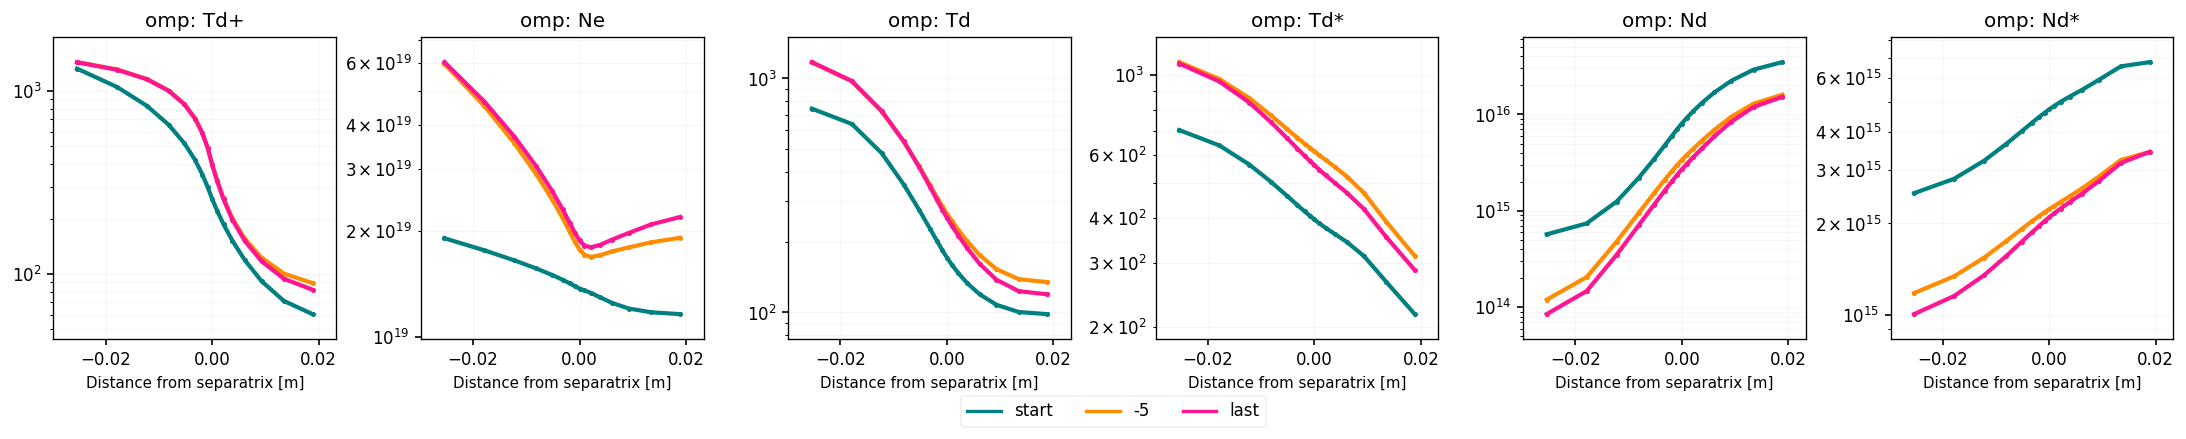

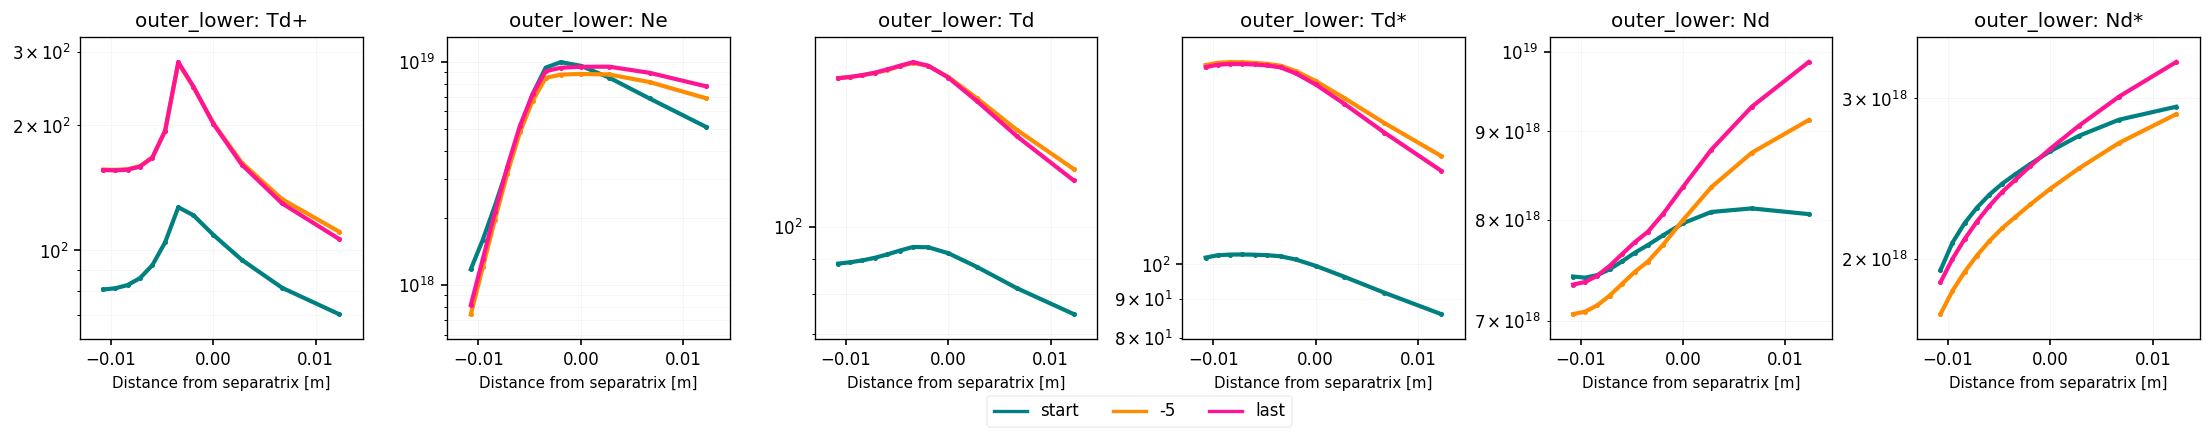

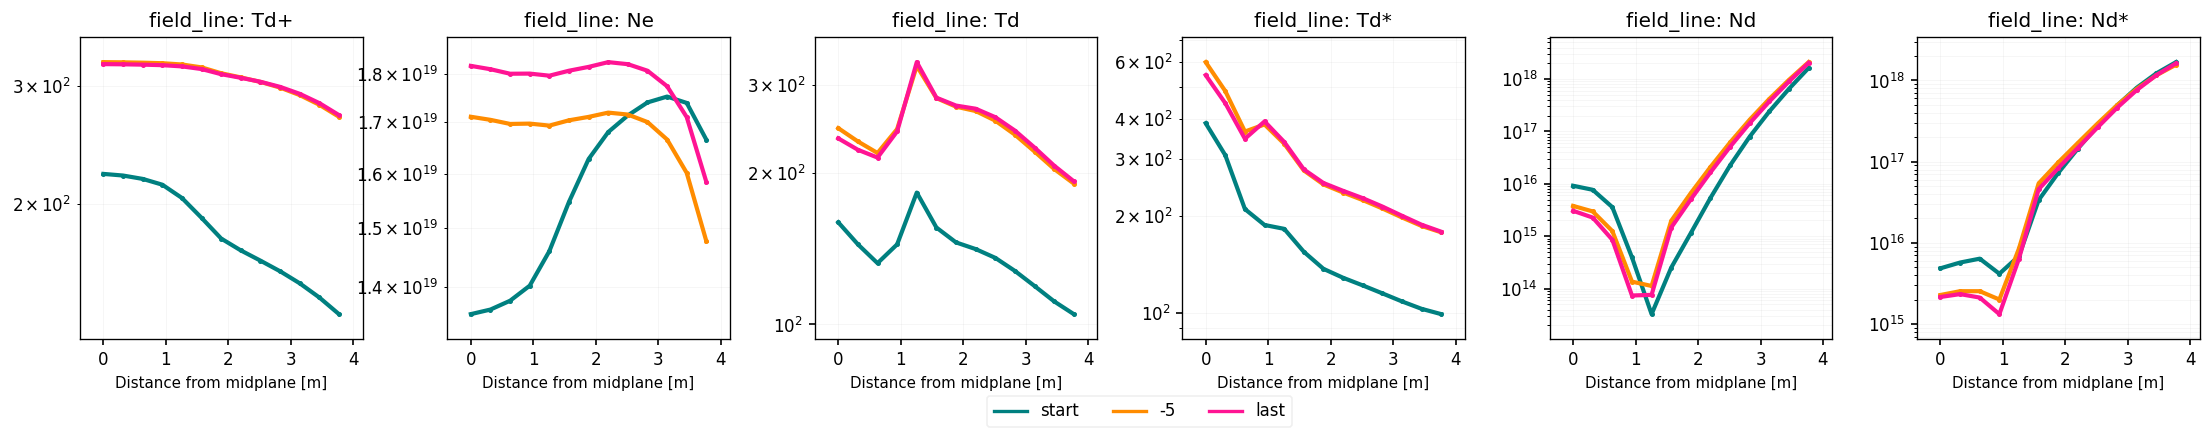

In [12]:
name = "weight_hot2"

lineplot(
    {
        "start":cs[name].ds.isel(t=0),
        "-5":cs[name].ds.isel(t=-5),
        "last":cs[name].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Ne", "Td", "Td*", "Nd", "Nd*"],
    regions = ["omp", "outer_lower", "field_line"],
)

In [ ]:
ds = cs["sol_neutbc"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)

(ds["Sdd*_refl"] * ds["dv"]).sum()

Text(0.5, 1.0, 'd* -> d reflection channel')

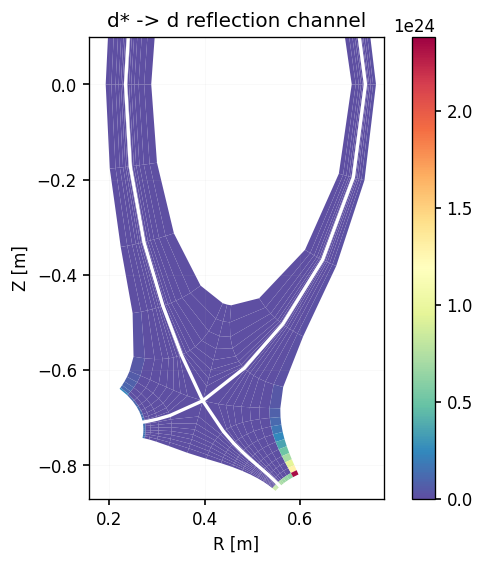

In [24]:
ds = cs["sol_neutbc"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)

fig,ax = plt.subplots()
(ds["Sdd*_wall_refl"] + ds["Sdd*_target_refl"]).hermesm.clean_guards().bout.polygon(ax = ax, cmap = "Spectral_r", antialias = True)

ax.set_ylim(-0.87,0.1)
ax.set_title("d* -> d reflection channel")

In [10]:
cs.keys()

dict_keys(['sol_neutbc', 'hotcx_iz', 'puff'])

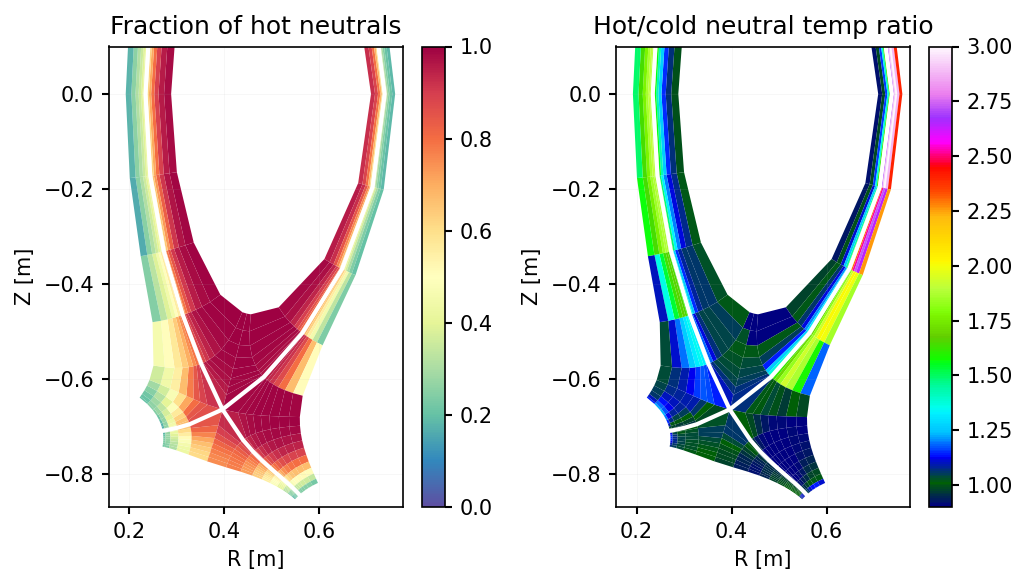

In [13]:
fig, axes = plt.subplots(1,2, dpi = 150, figsize = (7,4))

ds = cs["weight_hot2"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)

(ds["Nd*"] / (ds["Nd*"] + ds["Nd"])).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, vmin = 0, vmax = 1)
(ds["Td*"] / ds["Td"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "gist_ncar", antialias = True, vmin = 0.9, vmax = 3.0)

axes[0].set_title("Fraction of hot neutrals")
axes[1].set_title("Hot/cold neutral temp ratio")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()

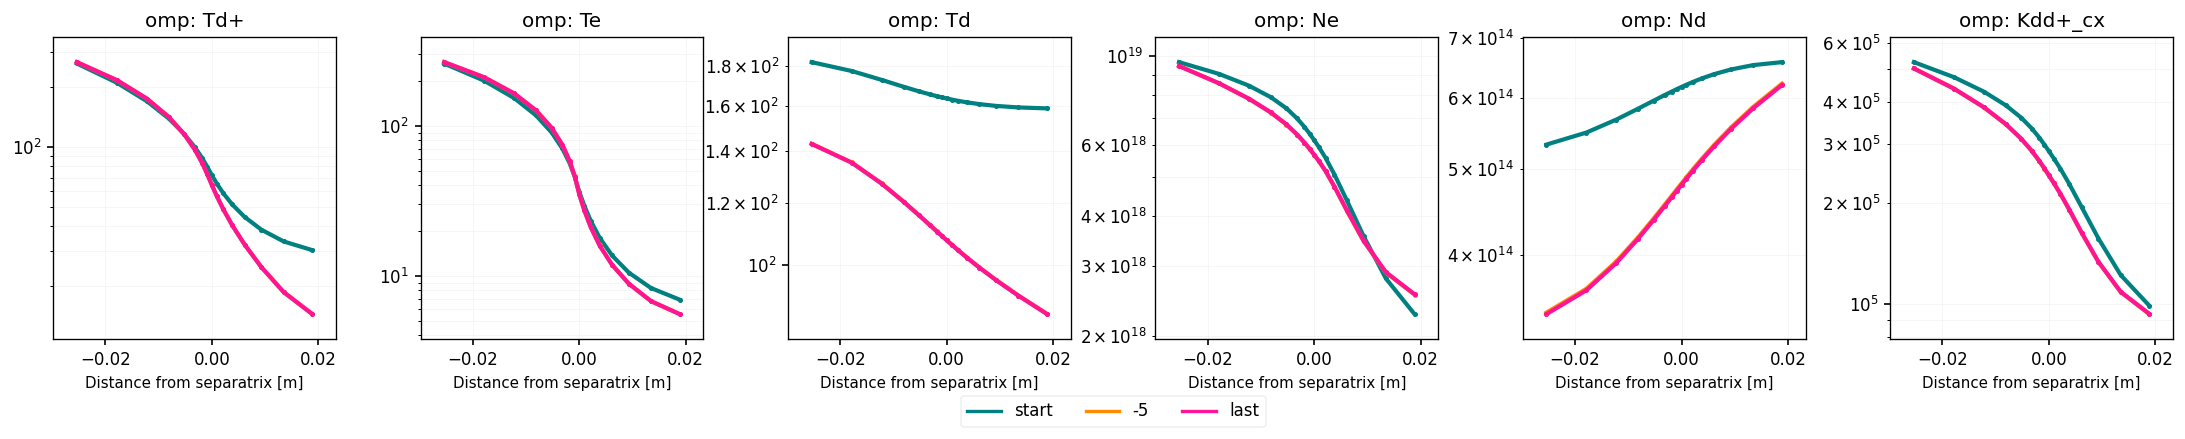

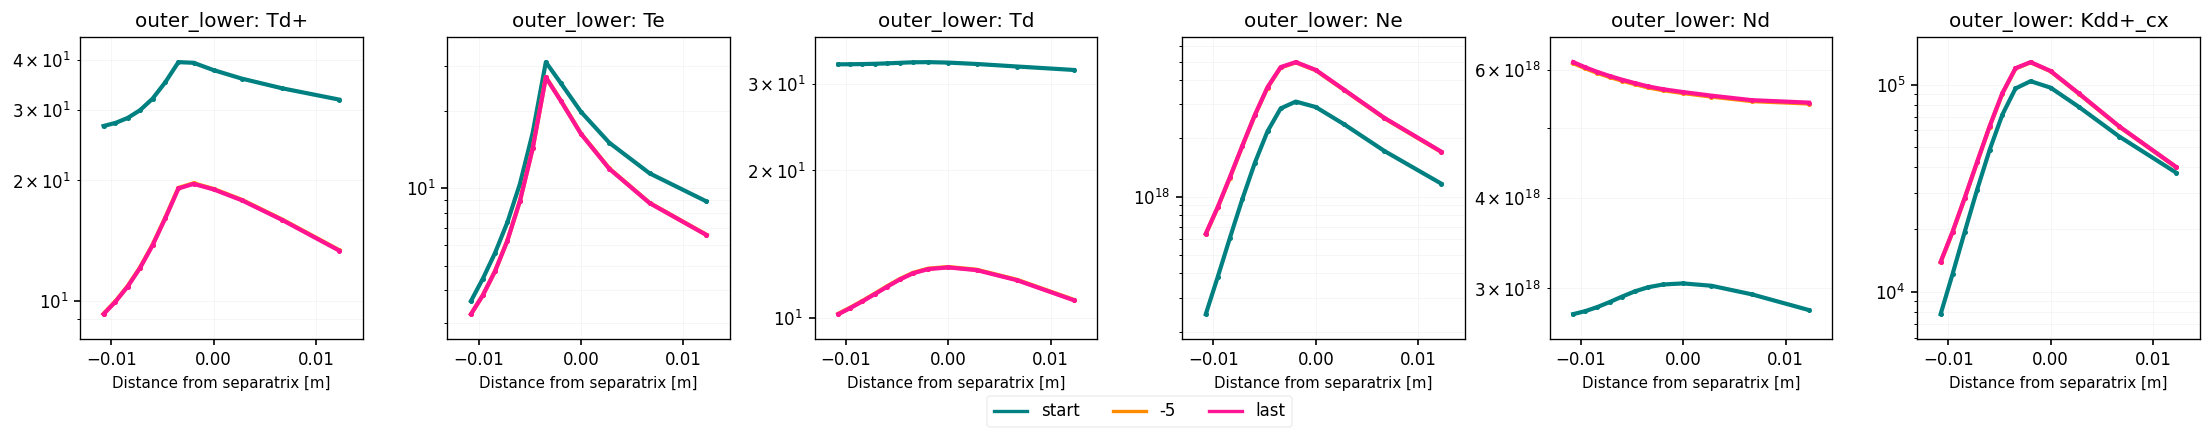

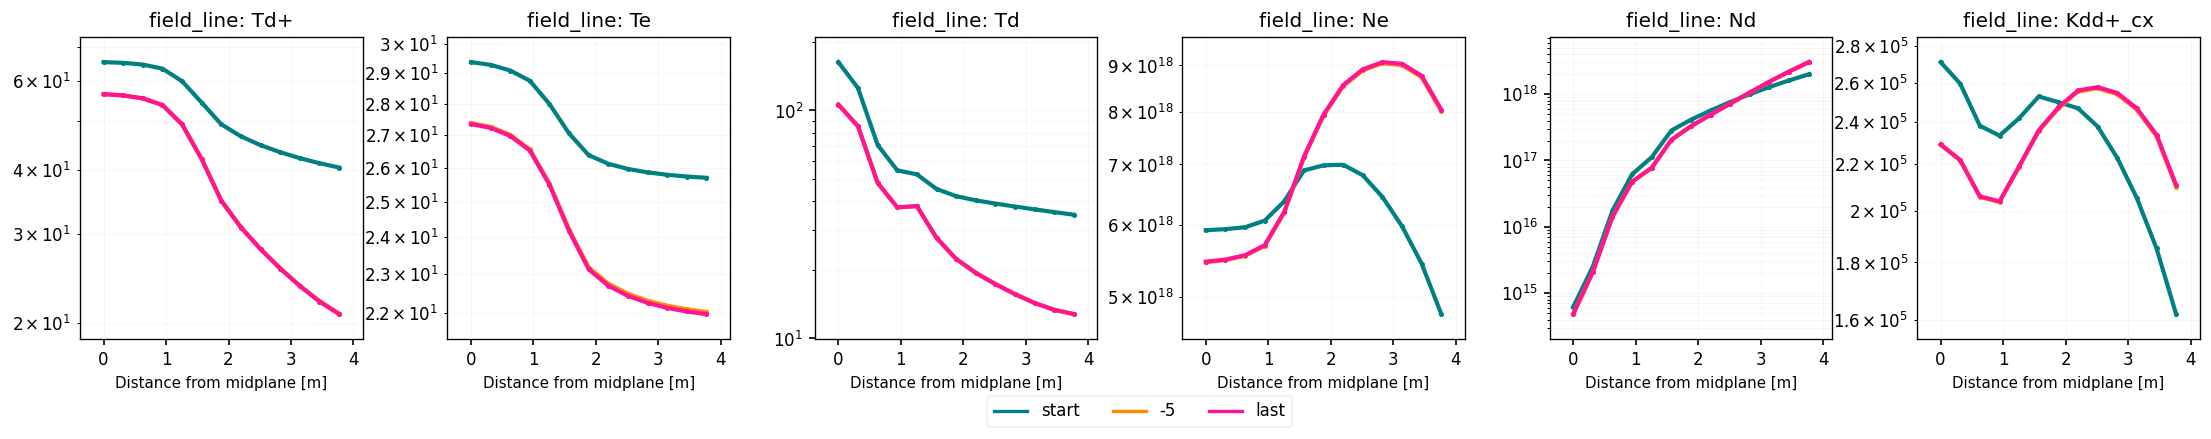

In [4]:
lineplot(
    {
        "start":casestore["base"].ds.isel(t=0),
        "-5":casestore["base"].ds.isel(t=-5),
        "last":casestore["base"].ds.isel(t=-1),

    },
    clean_guards = True,
    params = ["Td+", "Te", "Td", "Ne", "Nd", "Kdd+_cx"],
    regions = ["omp", "outer_lower", "field_line"],
)

## Fresh check

In [ ]:
print("Test case")
ds = casestore["test"].ds
m = ds.metadata
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

psrc = ds["Sd+_core_src"] * m["Omega_ci"] * m["Nnorm"]

particles = (psrc * ds["dv"]).sum()
print(f"Particles : {particles.values:.3e}")

if "Ed+_core_src" in ds.data_vars:
    hsrc = ds["Ed+_core_src"] * m["Tnorm"]*constants("q_e") * m["Omega_ci"] * m["Nnorm"]

    power = (hsrc * ds["dv"]).sum()
    print(f"Power : {power.values:.3e}")

print("\nGridsrc case")
ds = casestore["src"].ds
m = ds.metadata
if "t" in ds.dims.keys(): ds = ds.isel(t=-1)

psrc = ds["Sd+_src"] 
particles = (psrc * ds["dv"]).sum()
print(f"Particles : {particles.values:.3e}")

Test case
Particles : 5.020e+20

Gridsrc case
Particles : 5.020e+20


# Find fluxes coming from the core

In [5]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, new_afn = False)
    casestore[name].ds = reverse_pfr_fluxes(casestore[name].ds)
    # casestore[name].ds = calculate_target_fluxes(casestore[name].ds)

In [6]:

print("\n************************")
print("base")
print("************************")

ds = casestore["base"].ds
core = ds.hermesm.select_region("core_edge")
pflow = core["pf_perp_diff_L_d+"].sum("theta").squeeze()
hflow_i = core["hf_perp_diff_L_d+"].sum("theta").squeeze()
hflow_e = core["hf_perp_diff_L_e"].sum("theta").squeeze()
print(f"Total particle flow: {pflow[-1]:.2e} s^-1")
print(f"Total ion heat flow: {hflow_i[-1]:.2e} W")
print(f"Total electron heat flow: {hflow_e[-1]:.2e} W")

print("\n************************")
print("test")
print("************************")

ds = casestore["test"].ds
core = ds.hermesm.select_region("core_edge")
pflow = core["pf_perp_diff_R_d+"].sum("theta").squeeze()
hflow_i = core["hf_perp_diff_R_d+"].sum("theta").squeeze()
hflow_e = core["hf_perp_diff_R_e"].sum("theta").squeeze()
print()
print(f"Total particle flow:     {pflow[-1]:.2e} s^-1")
print(f"Reference particle flow: 5.02e+20 s^-1")
print()
print(f"Total ion heat flow:     {hflow_i[-1]:.2e} W")
print(f"Reference ion heat flow: 2.20e+04 W")
print()
print(f"Total electron heat flow:     {hflow_e[-1]:.2e} W")
print(f"Reference electron heat flow: 2.65e+04 W")

print("\n************************")
print("src")
print("************************")

ds = casestore["src"].ds
core = ds.hermesm.select_region("core_edge")
pflow = core["pf_perp_diff_R_d+"].sum("theta").squeeze()
hflow_i = core["hf_perp_diff_R_d+"].sum("theta").squeeze()
hflow_e = core["hf_perp_diff_R_e"].sum("theta").squeeze()
print()
print(f"Total particle flow:     {pflow[-1]:.2e} s^-1")
print(f"Reference particle flow: 5.02e+20 s^-1")
# print()
# print(f"Total ion heat flow:     {hflow_i[-1]:.2e} W")
# print(f"Reference ion heat flow: 2.20e+04 W")
# print()
# print(f"Total electron heat flow:     {hflow_e[-1]:.2e} W")
# print(f"Reference electron heat flow: 2.65e+04 W")
# hflow.plot()


************************
base
************************
Total particle flow: 3.53e+20 s^-1
Total ion heat flow: 2.34e+04 W
Total electron heat flow: 2.66e+04 W

************************
test
************************

Total particle flow:     1.12e+21 s^-1
Reference particle flow: 5.02e+20 s^-1

Total ion heat flow:     1.23e+04 W
Reference ion heat flow: 2.20e+04 W

Total electron heat flow:     1.46e+04 W
Reference electron heat flow: 2.65e+04 W

************************
src
************************

Total particle flow:     5.00e+20 s^-1
Reference particle flow: 5.02e+20 s^-1


# Add puff

Total flow: 1.2e+21 [s-1]
Total flow per volume: 1.92e+23 [s-1 m-3]
Total heat source: 5.77e+02 [W]
Total heat source per volume: 9.23e+04 [W m-3]

>>> Field Nd_src already exists in /ssd_scratch/hcases/g3b2-test_puff.nc, it will be overwritten
-> Wrote field Nd_src to /ssd_scratch/hcases/g3b2-test_puff.nc
>>> Field Pd_src already exists in /ssd_scratch/hcases/g3b2-test_puff.nc, it will be overwritten
-> Wrote field Pd_src to /ssd_scratch/hcases/g3b2-test_puff.nc
Mesh file /ssd_scratch/hcases/g3b2-test_puff.nc closed


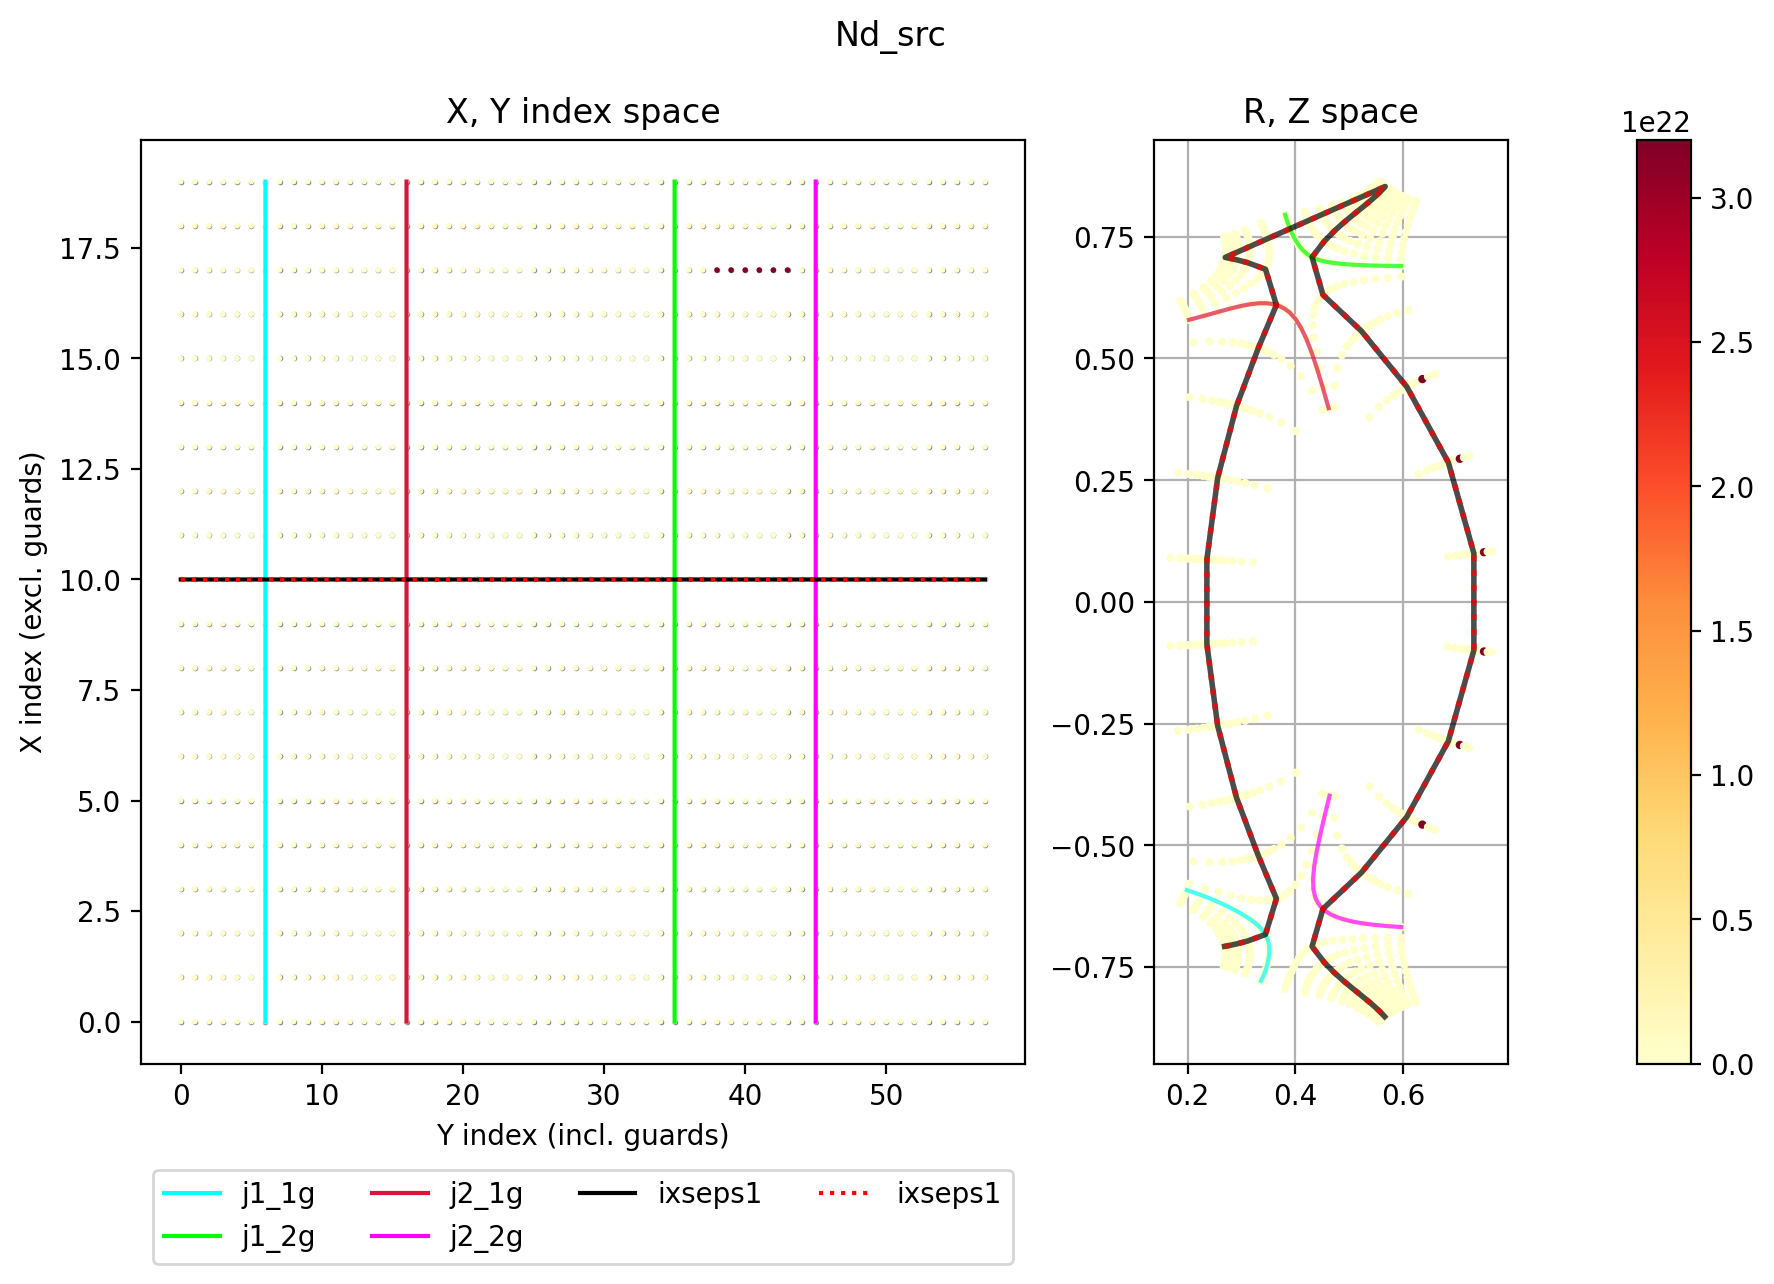

In [4]:
plt.close("all")
mesh = Mesh(r"/ssd_scratch/hcases/g3b2-test_puff.nc")
self = mesh

midplane_a = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g
midplane_b = int((self.j2_2g - self.j1_2g) / 2) + self.j1_2g + 1


# puff_indices = [2, 5, 8]   # fine grid
puff_indices = [0,1,2]   # SOLEDGE puff, coarse grid

selection =  (-self.MXG-1, 
            np.r_[
                [midplane_a-x for x in puff_indices],
                [midplane_b+x for x in puff_indices]
                ])
            
# puff_region = mesh.slices("symmetric_puff")(width=3, center_half_gap=1)
puff_region = selection

mesh.mesh["dv"] = mesh.mesh["dy"] * mesh.mesh["dx"] * mesh.mesh["J"] * 2*np.pi
volume = mesh.mesh["dv"][puff_region]

total_flow = 1.2e21   # atoms per second

total_flow_per_volume = total_flow * (volume/volume.sum()) / volume  # first find how much per cell, then per volume
print(f"Total flow: {total_flow} [s-1]")
print(f"Total flow per volume: {total_flow_per_volume.sum():.2e} [s-1 m-3]")

heat_source = 1.2e21 * 3 * constants("q_e")  #  3eV per particle (assume dissociated molecules)
heat_source_per_volume = heat_source * (volume/volume.sum()) / volume 
print(f"Total heat source: {heat_source:.2e} [W]")
print(f"Total heat source per volume: {heat_source_per_volume.sum():.2e} [W m-3]")


Pd_src = Field("Pd_src", mesh)
Nd_src = Field("Nd_src", mesh)

print()

Nd_src.data[puff_region] = total_flow_per_volume
Pd_src.data[puff_region] = heat_source_per_volume
mesh.write_field(Nd_src)
mesh.write_field(Pd_src)

Nd_src.plot(dpi = 200)


try:
    mesh.close()
    del mesh
except:
    pass

# Other PP

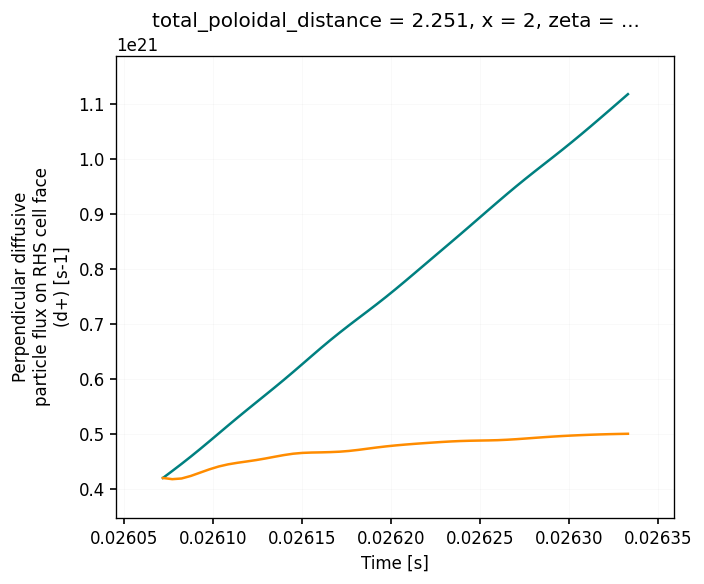

In [9]:
fig, ax = plt.subplots()

ds = casestore["test"].ds 
core = ds.hermesm.select_region("core_edge")
pflow = core["pf_perp_diff_R_d+"].sum("theta").squeeze()
pflow.plot(ax = ax, label = "test")

ds = casestore["src"].ds 
core = ds.hermesm.select_region("core_edge")
pflow = core["pf_perp_diff_R_d+"].sum("theta").squeeze()
pflow.plot(ax = ax, label = "src")

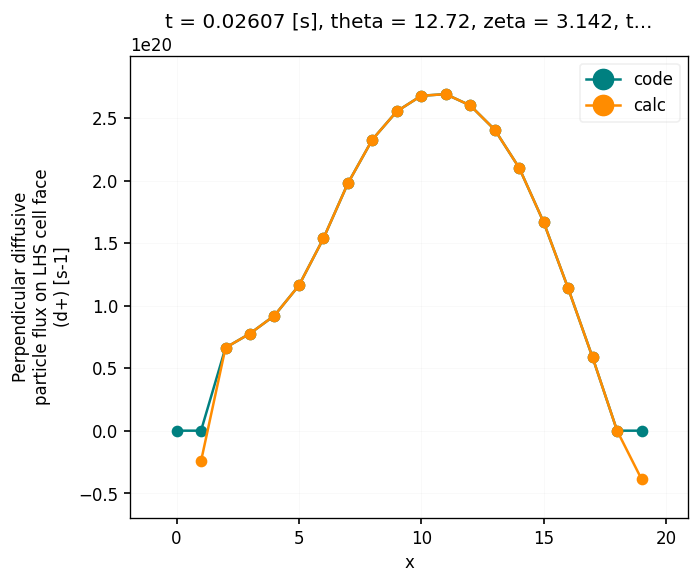

In [26]:
ds = casestore["base"].ds.isel(t=-1)
core2 = ds.hermesm.select_custom_core_ring(0)
core2["ParticleFlow_d+_xlow"].sum().values

fig, ax = plt.subplots()
omp = ds.hermesm.select_region("outer_midplane_a")
omp["ParticleFlow_d+_xlow"].plot(ax=ax, label = "code", marker = "o")
omp["pf_perp_diff_L_d+"].plot(ax=ax, label = "calc", marker = "o")
ax.legend()


# Check sources from tokamak_core

In [9]:
ds["Sd+"]

Data variables:
    Bxy                   (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed+_iz                (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed+_rec               (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed_target_recycle     (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Edd+_cx               (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow    (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow    (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_e_xlow     (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_e_ylow     (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Fd+_iz                (x, theta) float64 dask.array<chunksiz

In [10]:
ds = casestore["test"].ds
if "t" in ds.dims.keys():
    ds = ds.isel(t=-1)
m = ds.metadata
hfnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e") * m["Omega_ci"]
pfnorm = m["Nnorm"] * m["Omega_ci"]
volnorm = m["rho_s0"]**3

core = ds.hermesm.select_region("core_edge")
vol = core["dv"].sum().values / volnorm



# power_in = 2.20e-02 * 1e6 / (m["Tnorm"] * constants("q_e") * m["Omega_ci"])
# psrc_calc = power_in / vol
# psrc_code = core["Ed+_core_src"].squeeze().values[0]
# ptot_code = (ds["Ed+_core_src"]  * ds["dv"]).sum().values * (m["Tnorm"] * constants("q_e") * m["Omega_ci"] / m["rho_s0"]**3)

particles_in = 5.02e+20 / m["Omega_ci"]
particle_src_calc = particles_in / vol
particle_src_code = core["Sd+_core_src"].squeeze().values[0]
particle_tot_code = (ds["Sd+_core_src"] * ds["dv"]).sum().values * (m["Omega_ci"] / m["rho_s0"]**3)

# print(f"Power source calc: {psrc_calc:.2e} [-]")
# print(f"Power source code: {psrc_code:.2e} [-]")
# print(f"Total power input: {ptot_code:.2e} [W]")
print("\n")
print(f"Particle source calc: {particle_src_calc:.2e} [-]")
print(f"Particle source code: {particle_src_code:.2e} [-]")
print(f"Total particle input: {particle_tot_code:.2e} [s^-1]")
# print(vol)
# power_i = (ds["Ed+_core_src"] * hfnorm * ds["dv"]).sum().values 
# pflux_i = (ds["Sd+_core_src"] * pfnorm * ds["dv"]).sum().values
# print(pflux_i)




Particle source calc: 5.15e+04 [-]
Particle source code: 5.15e+04 [-]
Total particle input: 5.02e+20 [s^-1]


In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (8,6))
(casestore["base"].ds["Te"]).hermesm.clean_guards().bout.polygon(ax = axes[0], vmax = 100, cmap = "Spectral_r", antialias = True)
(casestore["test"].ds["Te"]).hermesm.clean_guards().bout.polygon(ax = axes[1], vmax = 100, cmap = "Spectral_r", antialias = True)

fig, axes = plt.subplots(1, 2, figsize = (8,6))
(casestore["base"].ds["Ne"]).hermesm.clean_guards().bout.polygon(ax = axes[0], vmax = 5e18, cmap = "Spectral_r", antialias = True)
(casestore["test"].ds["Ne"]).hermesm.clean_guards().bout.polygon(ax = axes[1], vmax = 5e18, cmap = "Spectral_r", antialias = True)

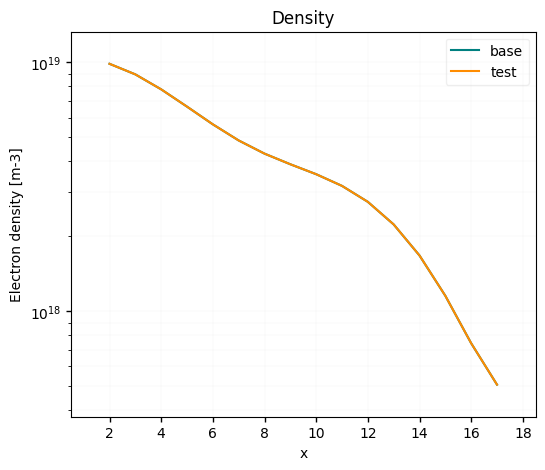

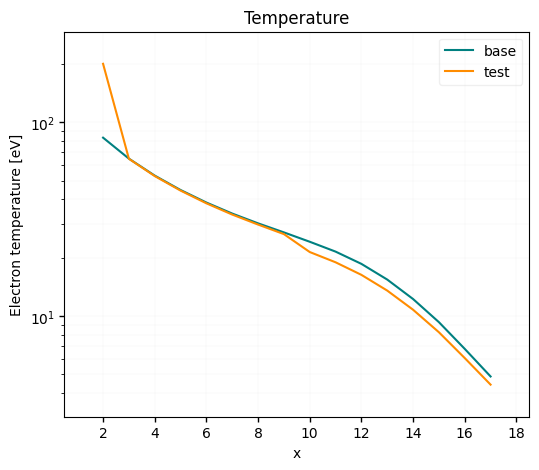

In [16]:
fig, ax = plt.subplots(dpi = 100)

for case in ["base", "test"]:
    ds = casestore["base"].ds
    omp = ds.hermesm.select_region("outer_midplane_b").isel(x=slice(2,-2))
    omp.isel(t=-1)["Ne"].plot(ax = ax, label = case)
ax.set_title("Density")
ax.set_yscale("log")
ax.legend()

fig, ax = plt.subplots(dpi = 100)

for case in ["base", "test"]:
    ds = casestore[case].ds
    omp = ds.hermesm.select_region("outer_midplane_b").isel(x=slice(2,-2))
    omp.isel(t=-1)["Te"].plot(ax = ax, label = case)
ax.set_title("Temperature")

ax.set_yscale("log")
ax.legend()
# omp.isel(t=0)["Te"].plot(ax = ax, label = "Before")
# omp.isel(t=1)["Ne"].plot(ax = ax, label = "After")

# Put sources in grid

Defining dimension z of size 1
>>> Field Nd+_src already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field Nd+_src to /ssd_scratch/hcases/g3c1-tokamcore_test.nc
>>> Field Pd+_src already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field Pd+_src to /ssd_scratch/hcases/g3c1-tokamcore_test.nc
>>> Field Pe_src already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field Pe_src to /ssd_scratch/hcases/g3c1-tokamcore_test.nc
>>> Field D_d+ already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field D_d+ to /ssd_scratch/hcases/g3c1-tokamcore_test.nc
>>> Field D_e already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field D_e to /ssd_scratch/hcases/g3c1-tokamcore_test.nc
>>> Field chi_d+ already exists in /ssd_scratch/hcases/g3c1-tokamcore_test.nc, it will be overwritten
-> Wrote field chi_d+ t

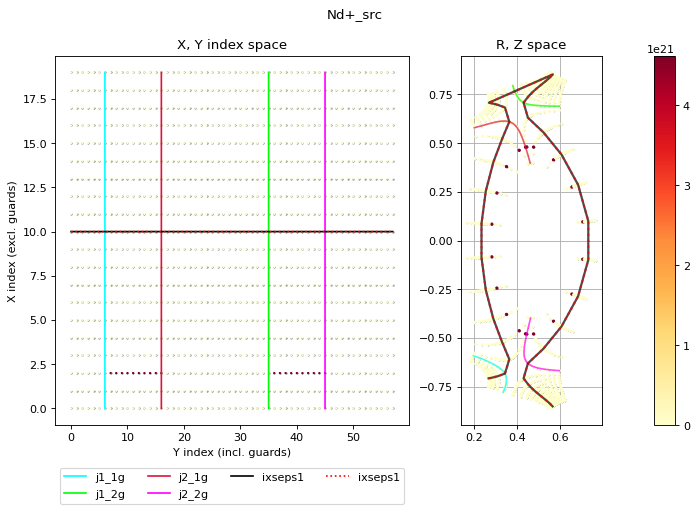

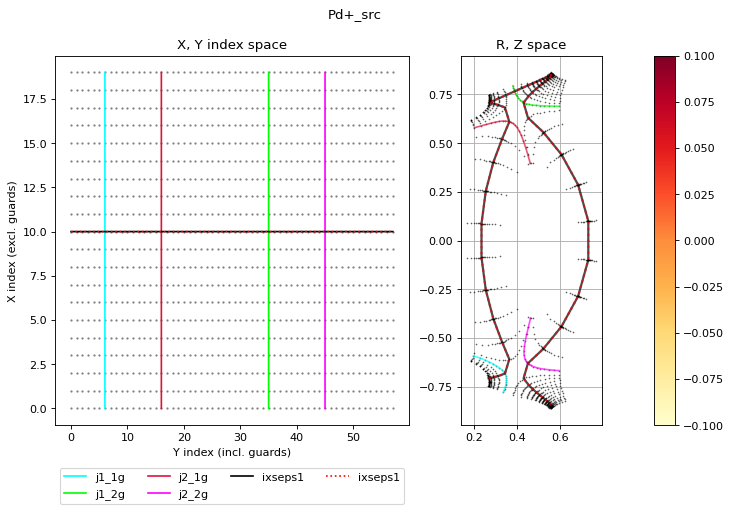

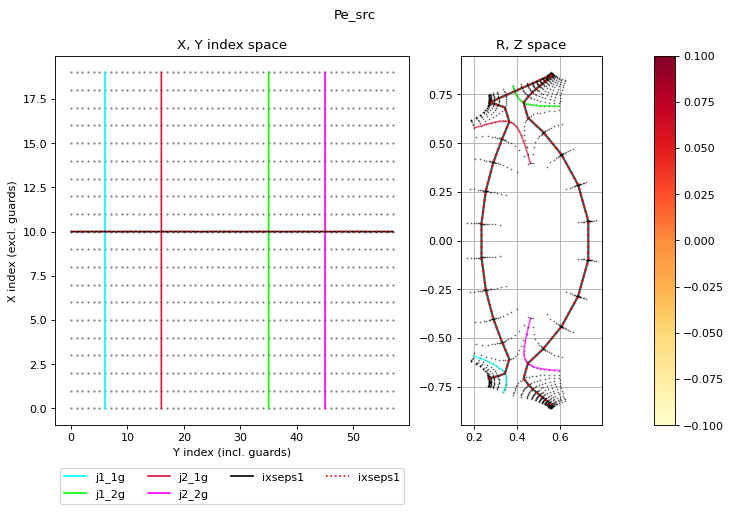

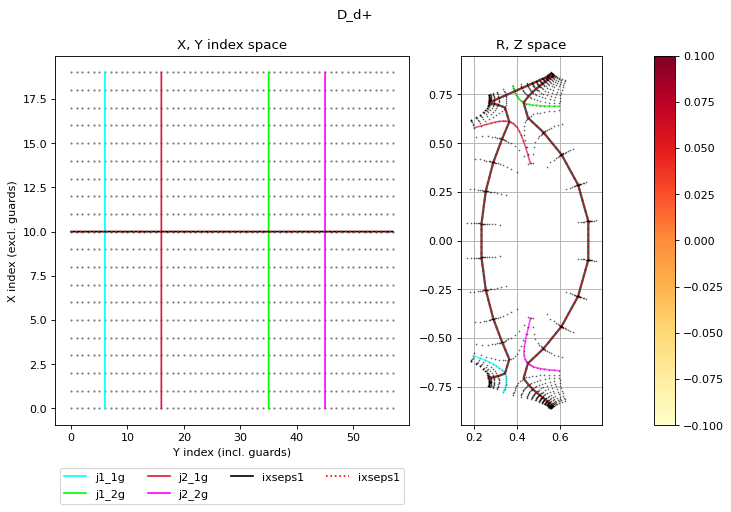

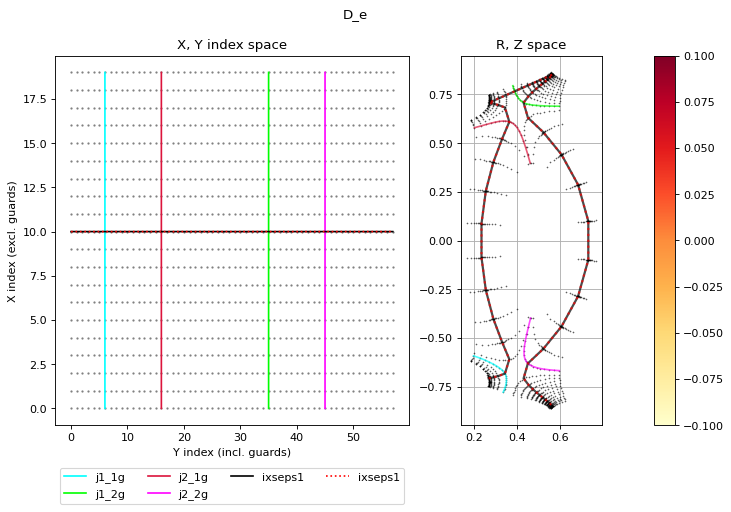

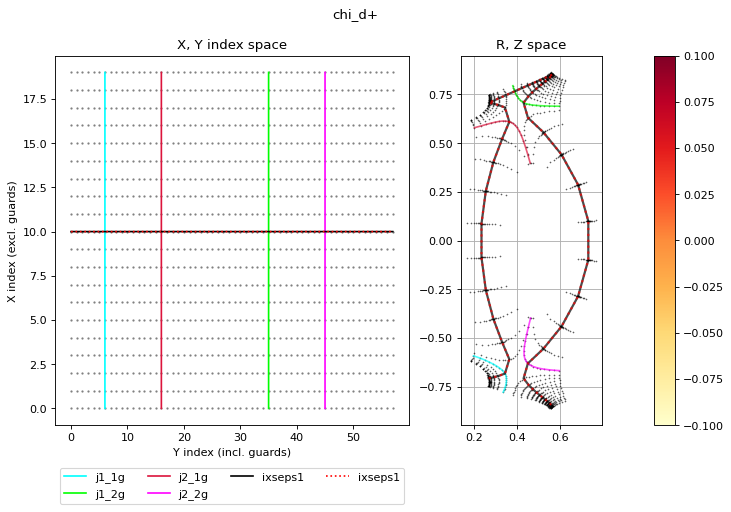

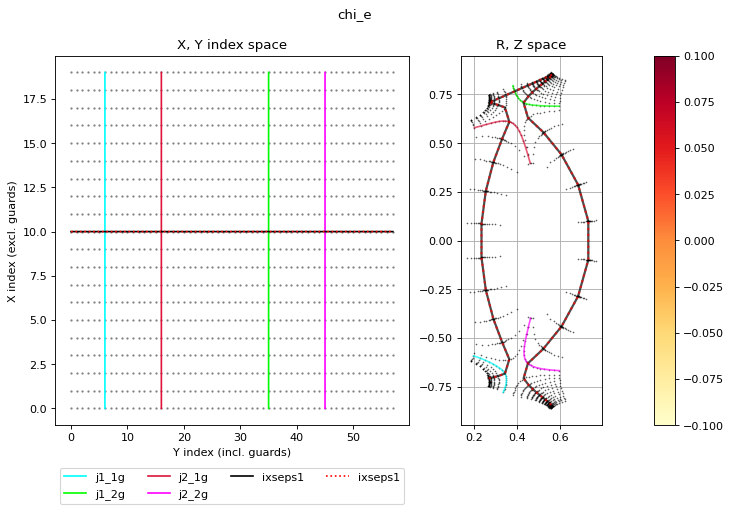

In [19]:
from hermes3.grid_fields import *

impose_fields(
    source = r"/ssd_scratch/hcases/g3b1-lores_newhypno.nc",
    destination = r"/ssd_scratch/hcases/g3c1-tokamcore_test.nc",
    Ni_src_core = 5.02e+20,
)